# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking-dev/notebooks'

In [2]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [3]:
# Notebook utils
from nb_utils import (get_test_data_loader, load_config, load_summaries,
                      load_model, apply_model, compute_metrics,
                      plot_train_history, draw_sample, plot_metrics)

In [4]:
%matplotlib inline

In [5]:
# Config path
config_file = '../configs/mpnn_big.yaml'

In [6]:
!cat $config_file

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `module'
output_dir: ${SCRATCH}/heptrkx/results/resmpnn_big_001

trainer:
    name: gnn_sparse
    real_weight: 2.5   # 0.5 / 0.2
    fake_weight: 0.625 # 0.5 / 0.8

data:
    name: hitgraphs_sparse
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_big_000
    n_train: 32768
    n_valid: 4096
    batch_size: 1
    n_workers: 4

model:
    name: mpnn
    input_dim: 3
    hidden_node_dim: 64
    hidden_edge_dim: 64
    n_graph_iters: 8
    loss_func: 'binary_cross_entropy_with_logits'
    optimizer: 'Adam'
    learning_rate: 0.001

training:
    n_epochs: 96


In [7]:
config = load_config(config_file)
summaries = load_summaries(config)

/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking-dev/notebooks/nb_utils.py:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


In [8]:
config

{'output_dir': '${SCRATCH}/heptrkx/results/resmpnn_big_001',
 'trainer': {'name': 'gnn_sparse', 'real_weight': 2.5, 'fake_weight': 0.625},
 'data': {'name': 'hitgraphs_sparse',
  'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_big_000',
  'n_train': 32768,
  'n_valid': 4096,
  'batch_size': 1,
  'n_workers': 4},
 'model': {'name': 'mpnn',
  'input_dim': 3,
  'hidden_node_dim': 64,
  'hidden_edge_dim': 64,
  'n_graph_iters': 8,
  'loss_func': 'binary_cross_entropy_with_logits',
  'optimizer': 'Adam',
  'learning_rate': 0.001},
 'training': {'n_epochs': 96}}

In [9]:
summaries

,epoch,lr,train_loss,train_time,valid_acc,valid_loss,valid_time
0,0,0.001,0.157513,1890.308105,0.962340,0.094791,66.025640
1,1,0.001,0.087861,1884.753618,0.961377,0.102336,69.471037
2,2,0.001,0.076527,1872.046947,0.972168,0.073149,67.048209
3,3,0.001,0.073950,1875.660117,0.977933,0.060740,66.043995
4,4,0.001,0.064325,1858.583396,0.980450,0.055885,66.907977
5,5,0.001,0.057871,1854.636935,0.984397,0.046169,65.756587
6,6,0.001,0.053368,1833.021787,0.983432,0.049944,66.094573
7,7,0.001,0.049891,1932.182288,0.981798,0.051533,65.767883
8,8,0.001,0.047552,1850.305992,0.985311,0.041762,70.427015
9,9,0.001,0.046608,1863.592895,0.986703,0.039442,65.903245


## Plot the Training loss and accuracy

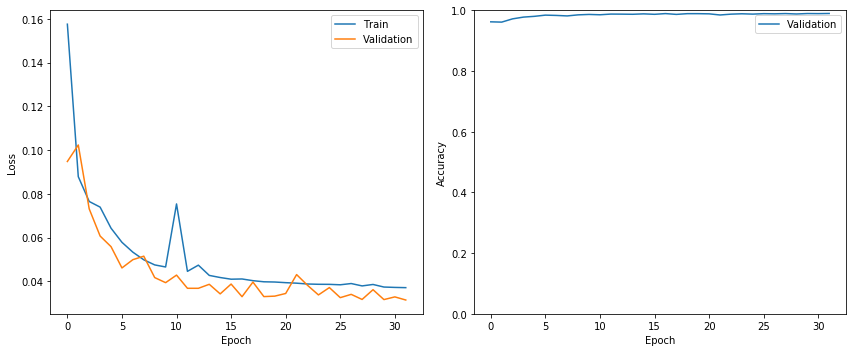

In [10]:
plot_train_history(summaries)

## Load the trained model

In [11]:
# Find the best epoch
best_summary = summaries.loc[[summaries.valid_loss.idxmin()]]
best_summary

,epoch,lr,train_loss,train_time,valid_acc,valid_loss,valid_time
31,31,0.001,0.037162,1978.827261,0.989847,0.031517,68.781922


In [12]:
# Load model from best epoch
model = load_model(config, reload_epoch=best_summary.epoch).eval()

print(model)
print('Parameters: %i' % sum(p.numel() for p in model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Laye

## Load the test data set

In [13]:
import torch
from torch.utils.data import Subset, DataLoader

from torch_geometric.data import Batch

from datasets.hitgraphs_sparse import HitGraphDataset

from nb_utils import get_input_dir

def get_dataset(config):
    return HitGraphDataset(get_input_dir(config))

def get_test_data_loader(config, n_test=16):
    # Take the test set from the back
    full_dataset = get_dataset(config)
    test_indices = len(full_dataset) - 1 - torch.arange(n_test)
    test_dataset = Subset(full_dataset, test_indices)
    return DataLoader(test_dataset, batch_size=1, collate_fn=Batch.from_data_list)

In [14]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

## Evaluate the model on the test dataset

In [15]:
import torch

@torch.no_grad()
def apply_model(model, data_loader):
    preds, targets = [], []
    for batch in data_loader:
        preds.append(torch.sigmoid(model(batch)).squeeze(0))
        targets.append(batch.y.squeeze(0))
    return preds, targets

In [16]:
%%time
test_preds, test_targets = apply_model(model, test_loader)

CPU times: user 2min 33s, sys: 2.93 s, total: 2min 36s
Wall time: 39.1 s


In [17]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9899
Precision: 0.9159
Recall:    0.9592


In [18]:
threshold = 0.6
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.6
Accuracy:  0.9911
Precision: 0.9358
Recall:    0.9521


In [19]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.7
Accuracy:  0.9920
Precision: 0.9562
Recall:    0.9414


In [20]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9924
Precision: 0.9741
Recall:    0.9278


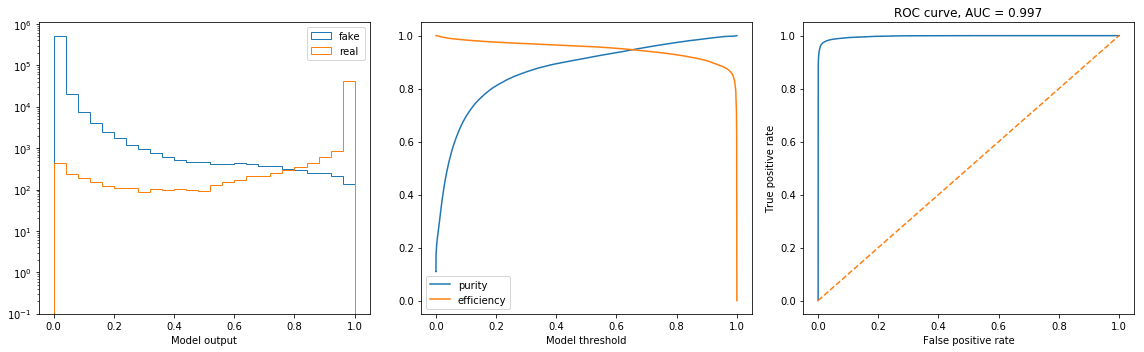

In [21]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [22]:
def draw_sample(data, cmap='bwr_r', alpha_labels=True, figsize=(15, 7)):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]

    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
    cmap = plt.get_cmap(cmap)

    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')

    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$')
    ax1.set_xlabel('$\phi$')
    ax0.set_ylabel('$r$')
    ax1.set_ylabel('$r$')
    plt.tight_layout()